KAPPA_MAG: 0.0006933655793381856
Integrator Order: 6
--- Generic N-th Order Symplectic Integrator Simulation ---
Running scenario: Case 1: QPM for SHG (Λ=7.20 μm)...
 -> Completed in 0.008 s. (Calculated 557 points)
Running scenario: Case 2: QPM for SFG (Λ≈1.96 μm)...
 -> Completed in 0.064 s. (Calculated 2452 points)
Running scenario: Case 3: Cascaded QPM for THG...
 -> Completed in 0.074 s. (Calculated 3008 points)

Generating plots...
Done.


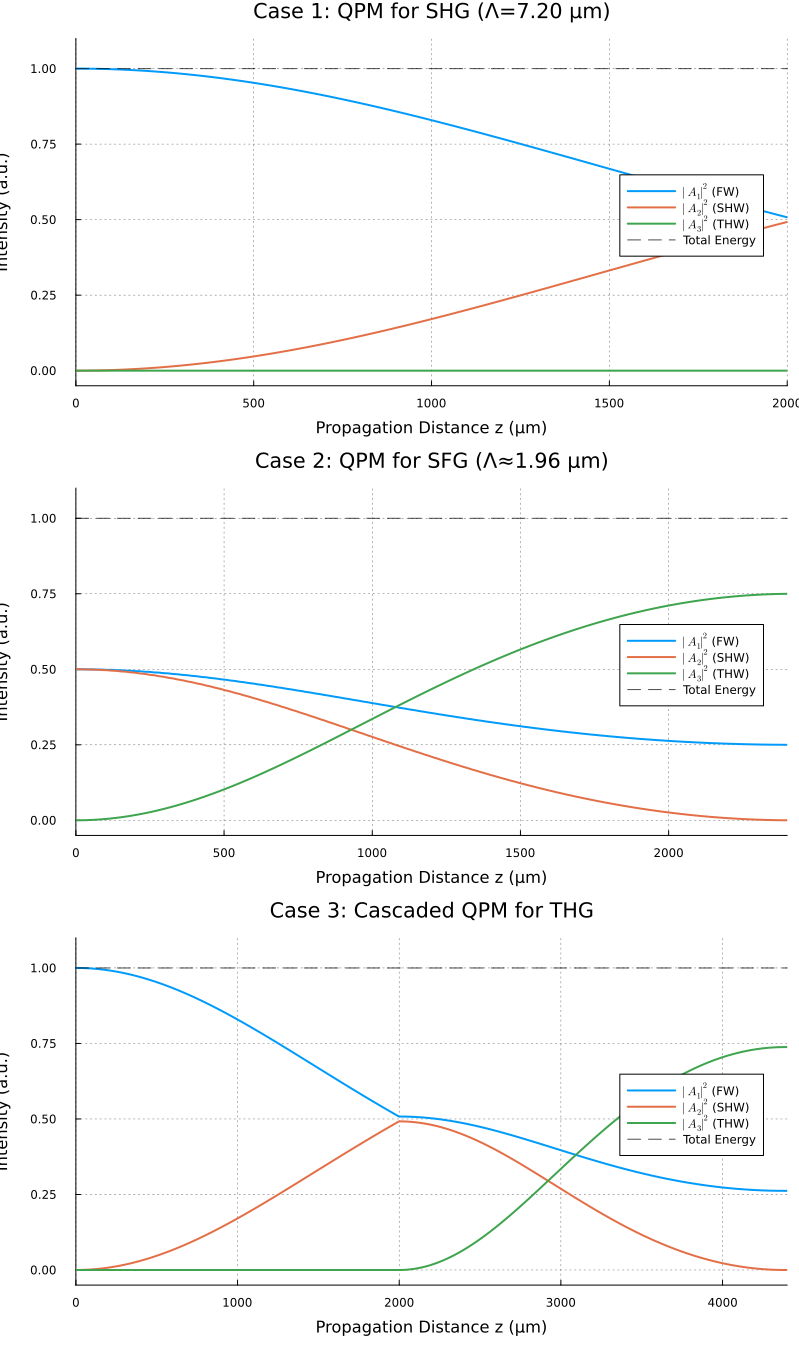

In [2]:
using LinearAlgebra
using Printf
using Plots
using LaTeXStrings

# --- Configuration Parameters ---
KAPPA_MAG = atanh(sqrt(0.95)) / 2000 * 2 / pi
INTEGRATOR_ORDER = 6 # これでも足りないから効率が悪い
MAX_FIXED_POINT_ITER = 4 # ここは小さくても結果への影響はほぼない

println("KAPPA_MAG: ", KAPPA_MAG)
println("Integrator Order: ", INTEGRATOR_ORDER)

# --- Core Physics Functions ---

"Linear operator L"
get_L(delta_k1, delta_k2) = 1im .* [0.0, delta_k1, delta_k1 + delta_k2]

"Nonlinear term N(B)"
function N(B::AbstractVector{<:Complex}, kappa::Float64)
    B1, B2, B3 = B
    NB1 = conj(B1) * B2 + conj(B2) * B3
    NB2 = B1^2 + 2 * conj(B1) * B3
    NB3 = 3 * B1 * B2
    return 1im * kappa .* [NB1, NB2, NB3]
end

"Convert B back to A for a given z"
function A_from_B(B::AbstractVector{<:Complex}, z::Float64, delta_k1::Float64, delta_k2::Float64)
    B1, B2, B3 = B
    A1 = B1
    A2 = B2 * exp(-1im * delta_k1 * z)
    A3 = B3 * exp(-1im * (delta_k1 + delta_k2) * z)
    return [A1, A2, A3]
end

# --- Domain Generation (Corrected Logic) ---
function generate_periodic_domains(z_start::Float64, z_end::Float64, period::Float64, kappa_mag::Float64)
    domains = Tuple{Float64,Float64}[]
    half_period = period / 2.0
    current_z = z_start
    sign_flipper = 1.0 # Reset for each call to ensure correct starting phase

    while current_z < z_end
        h = min(half_period, z_end - current_z)
        (h < 1e-12) && break
        push!(domains, (h, sign_flipper * kappa_mag))
        current_z += h
        sign_flipper *= -1.0 # Toggle for the next segment
    end
    return domains
end

# ============================================================
#  General N-th Order Symplectic Integrator
# ============================================================

"""
Recursive Yoshida integrator step.
Constructs a `order`-th order integrator from a `(order-2)`-th order one.
The base case is the 2nd order Strang splitting method.
"""
function yoshida_step(B_in::Vector{ComplexF64}, h::Float64, L::Vector{ComplexF64}, kappa_val::Float64, order::Int)
    # Base Case: 2nd order Strang splitting (implicit midpoint for nonlinear part)
    if order == 2
        E_half = exp.((h / 2.0) .* L)
        B_step1 = E_half .* B_in

        # Implicit midpoint method solved with fixed-point iteration
        B_step2_k = copy(B_step1) # Initial guess
        for _ in 1:MAX_FIXED_POINT_ITER
            B_mid = (B_step2_k + B_step1) / 2.0
            NB_mid = N(B_mid, kappa_val)
            B_step2_k = B_step1 + h * NB_mid
        end

        return E_half .* B_step2_k
    end

    # Recursive Step: Build S_k from S_{k-2}
    # S_k(h) = S_{k-2}(c1*h) * S_{k-2}(c2*h) * S_{k-2}(c1*h)
    p = 1.0 / (order - 1.0)
    c1 = 1.0 / (2.0 - 2.0^p)
    c2 = -2.0^p / (2.0 - 2.0^p)

    B_mid1 = yoshida_step(B_in, c1 * h, L, kappa_val, order - 2)
    B_mid2 = yoshida_step(B_mid1, c2 * h, L, kappa_val, order - 2)
    B_out = yoshida_step(B_mid2, c1 * h, L, kappa_val, order - 2)

    return B_out
end

"""
Main solver function. Propagates the initial state B0 through all domains.
"""
function solve_system(B0, domains, L, order)
    if order % 2 != 0 || order < 2
        error("Integrator order must be an even integer >= 2.")
    end

    B = convert(Vector{ComplexF64}, B0)
    z = 0.0

    num_steps = length(domains)
    history_z = Vector{Float64}(undef, num_steps + 1)
    history_B = Vector{Vector{ComplexF64}}(undef, num_steps + 1)
    history_z[1] = z
    history_B[1] = copy(B)

    for (i, (h, kappa_val)) in enumerate(domains)
        B = yoshida_step(B, h, L, kappa_val, order)
        z += h
        history_z[i+1] = z
        history_B[i+1] = copy(B)
    end

    return history_z, history_B
end

# ============================================================
#  Scenarios and Execution
# ============================================================

struct Scenario
    name::String
    domains::Vector{Tuple{Float64,Float64}}
    A0::Vector{ComplexF64}
    delta_k1::Float64
    delta_k2::Float64
    z_max::Float64
end

function get_scenarios(KAPPA_MAG)
    DELTA_K1_SHG = 2 * pi / 7.2
    DELTA_K2_SFG = 3.2071
    period_shg = 2 * pi / DELTA_K1_SHG
    period_sfg = 2 * pi / DELTA_K2_SFG

    Z_MAX_1, Z_MAX_2, Z_MAX_3, Z_SPLIT = 2000.0, 2400.0, 4400.0, 2000.0

    domains_case1 = generate_periodic_domains(0.0, Z_MAX_1, period_shg, KAPPA_MAG)
    domains_case2 = generate_periodic_domains(0.0, Z_MAX_2, period_sfg, KAPPA_MAG)
    cascaded_domains = [
        generate_periodic_domains(0.0, Z_SPLIT, period_shg, KAPPA_MAG);
        generate_periodic_domains(Z_SPLIT, Z_MAX_3, period_sfg, KAPPA_MAG)
    ]

    return [
        Scenario(@sprintf("Case 1: QPM for SHG (Λ=%.2f μm)", period_shg),
            domains_case1, [1.0 + 0im, 0.0 + 0im, 0.0 + 0im], DELTA_K1_SHG, DELTA_K2_SFG, Z_MAX_1),
        Scenario(@sprintf("Case 2: QPM for SFG (Λ≈%.2f μm)", period_sfg),
            domains_case2, [sqrt(0.5) + 0im, sqrt(0.5) + 0im, 0.0 + 0im], DELTA_K1_SHG, DELTA_K2_SFG, Z_MAX_2),
        Scenario("Case 3: Cascaded QPM for THG",
            cascaded_domains, [1.0 + 0im, 0.0 + 0im, 0.0 + 0im], DELTA_K1_SHG, DELTA_K2_SFG, Z_MAX_3)
    ]
end

# --- Plotting and Analysis ---

function downsample_data(z::AbstractVector, A::AbstractMatrix, max_points::Int)
    n_total = length(z)
    (n_total <= max_points) && return z, A
    step = ceil(Int, n_total / max_points)
    indices = 1:step:n_total
    # Ensure the last point is always included
    return (indices[end] == n_total) ? (z[indices], A[indices, :]) : (z[[indices; n_total]], A[[indices; n_total], :])
end

function plot_overview(z, I, scenario_name, z_max)
    total_I = sum(I, dims=2)
    p = plot(z, I[:, 1], label=L"$|A_1|^2$ (FW)", linewidth=2, title=scenario_name, ylabel="Intensity (a.u.)", xlims=(0, z_max), legend=:right, grid=true, gridstyle=:dot, gridalpha=0.6, xlabel="Propagation Distance z (μm)")
    plot!(p, z, I[:, 2], label=L"$|A_2|^2$ (SHW)", linewidth=2)
    plot!(p, z, I[:, 3], label=L"$|A_3|^2$ (THW)", linewidth=2)
    plot!(p, z, total_I, label="Total Energy", linestyle=:dash, color=:black, alpha=0.7)
    ylims!(p, (-0.05, maximum(total_I) * 1.05 + 0.05))
    return p
end

# --- Simulation Runner ---

function run_simulations(scenarios, order::Int)
    results = Dict()
    for config in scenarios
        println("Running scenario: $(config.name)...")
        L = get_L(config.delta_k1, config.delta_k2)

        timed_result = @timed solve_system(config.A0, config.domains, L, order)
        duration = timed_result.time
        z, B_hist = timed_result.value
        @printf(" -> Completed in %.3f s. (Calculated %d points)\n", duration, length(z))

        A_hist_matrix = reduce(hcat, [A_from_B(B, zz, config.delta_k1, config.delta_k2) for (zz, B) in zip(z, B_hist)])'
        results[config.name] = Dict("z" => z, "A" => A_hist_matrix, "config" => config)
    end
    return results
end

# --- Main Execution Block ---
function main()
    println("--- Generic N-th Order Symplectic Integrator Simulation ---")
    scenarios = get_scenarios(KAPPA_MAG)
    results = run_simulations(scenarios, INTEGRATOR_ORDER)

    println("\nGenerating plots...")
    all_plots = Plots.Plot[]
    for config in scenarios
        result = results[config.name]
        z_full, A_full = result["z"], result["A"]
        I_full = abs2.(A_full)

        z_overview, I_overview = downsample_data(z_full, I_full, 1000)
        p_overview = plot_overview(z_overview, I_overview, config.name, config.z_max)
        push!(all_plots, p_overview)
    end

    num_scenarios = length(scenarios)
    p = plot(all_plots..., layout=(num_scenarios, 1), size=(800, 450 * num_scenarios), left_margin=5Plots.mm)
    display(p)

    println("Done.")
end

main()        